In [1]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import umap
import plotly.io as pio

from hbn.data import make_dataset
from hbn.visualization import visualize as vis

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# pio.renderers.default = 'iframe'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load diagnosis + demographic data

df, _ = make_dataset.get_clinical_diagnosis(demographics=True, target=None)
# df_score = make_dataset._add_CGAS_Score(df)
# df = df_score[['Identifiers', 'CGAS_Score']].merge(df, on='Identifiers')


In [3]:
## summary stats

sample_size = len(df['Identifiers'].unique())
print(f'1. total sample size is {sample_size}\n')

sex = df['Sex'].value_counts()
print(f'2. there are {sex.male} males and {sex.female} females\n')

ages_6_10 = len(df[df['Age'].round()<=10])
ages_10_21 = len(df[df['Age'].round()>10])
print(f'3. there are {ages_6_10} children ages 6-10 and {ages_10_21} children ages 11-21\n')

num_sites = len(df['Site'].unique())
print(f'4. there are {num_sites} study sites\n')

years = df['Enroll_Year'].value_counts().index.astype(str).str.strip('.0').astype(int).tolist()
num_years = len(df['Enroll_Year'].unique())
print(f'5. data were collected across {num_years} years: {years}\n')

num_disorders = len(df['DX_01'].unique())
num_cat = len(df['DX_01_Cat'].unique())
print(f'6. there are {num_disorders} unique disorders, classified under {num_cat} categories\n')

comorbid = round((df['comorbidities'].value_counts() / len(df)) * 100)
num_comorbid = comorbid[1:].sum()
print(f'7. approximately {num_comorbid}% have disorder combordities\n')

disorder = round((df['DX_01'].value_counts() / len(df)) * 100).head(1)
print(f'8. most prevalent diagnosis is {disorder.index[0]} - {disorder.values[0]}% of sample\n')

# sex = df.groupby(['Sex']).agg({'CGAS_Score': 'mean'})
# f_cgas = sex.loc['female'].values[0]
# m_cgas = sex.loc['male'].values[0]
# print(f'9. females have an average general functioning score of {round(f_cgas)}% and males {round(m_cgas)}%\n')



1. total sample size is 4106

2. there are 2626 males and 1480 females

3. there are 2394 children ages 6-10 and 1712 children ages 11-21

4. there are 5 study sites

5. data were collected across 7 years: [2018, 2019, 2017, 2016, 202, 2015, 2021]

6. there are 71 unique disorders, classified under 17 categories

7. approximately 59.0% have disorder combordities

8. most prevalent diagnosis is ADHD-Combined Type - 18.0% of sample



## Majority of sample (n=4106) is male (n=2626) and majority of sample are in the age range: 6-10 (n=2394)

In [4]:
fig = px.histogram(df, x="Age", nbins=10, color="Sex")
fig.show()

## Majority of people were enrolled between 2017 and 2019 with a roughly equal distribution of ages across the years

In [5]:
fig = px.histogram(df, x="Age", nbins=10, color="Sex")
fig.show()

## Majority of samples were collected in study site 1

In [6]:
fig = px.histogram(df, x="Site", color="Enroll_Year", nbins=5)
fig.show()

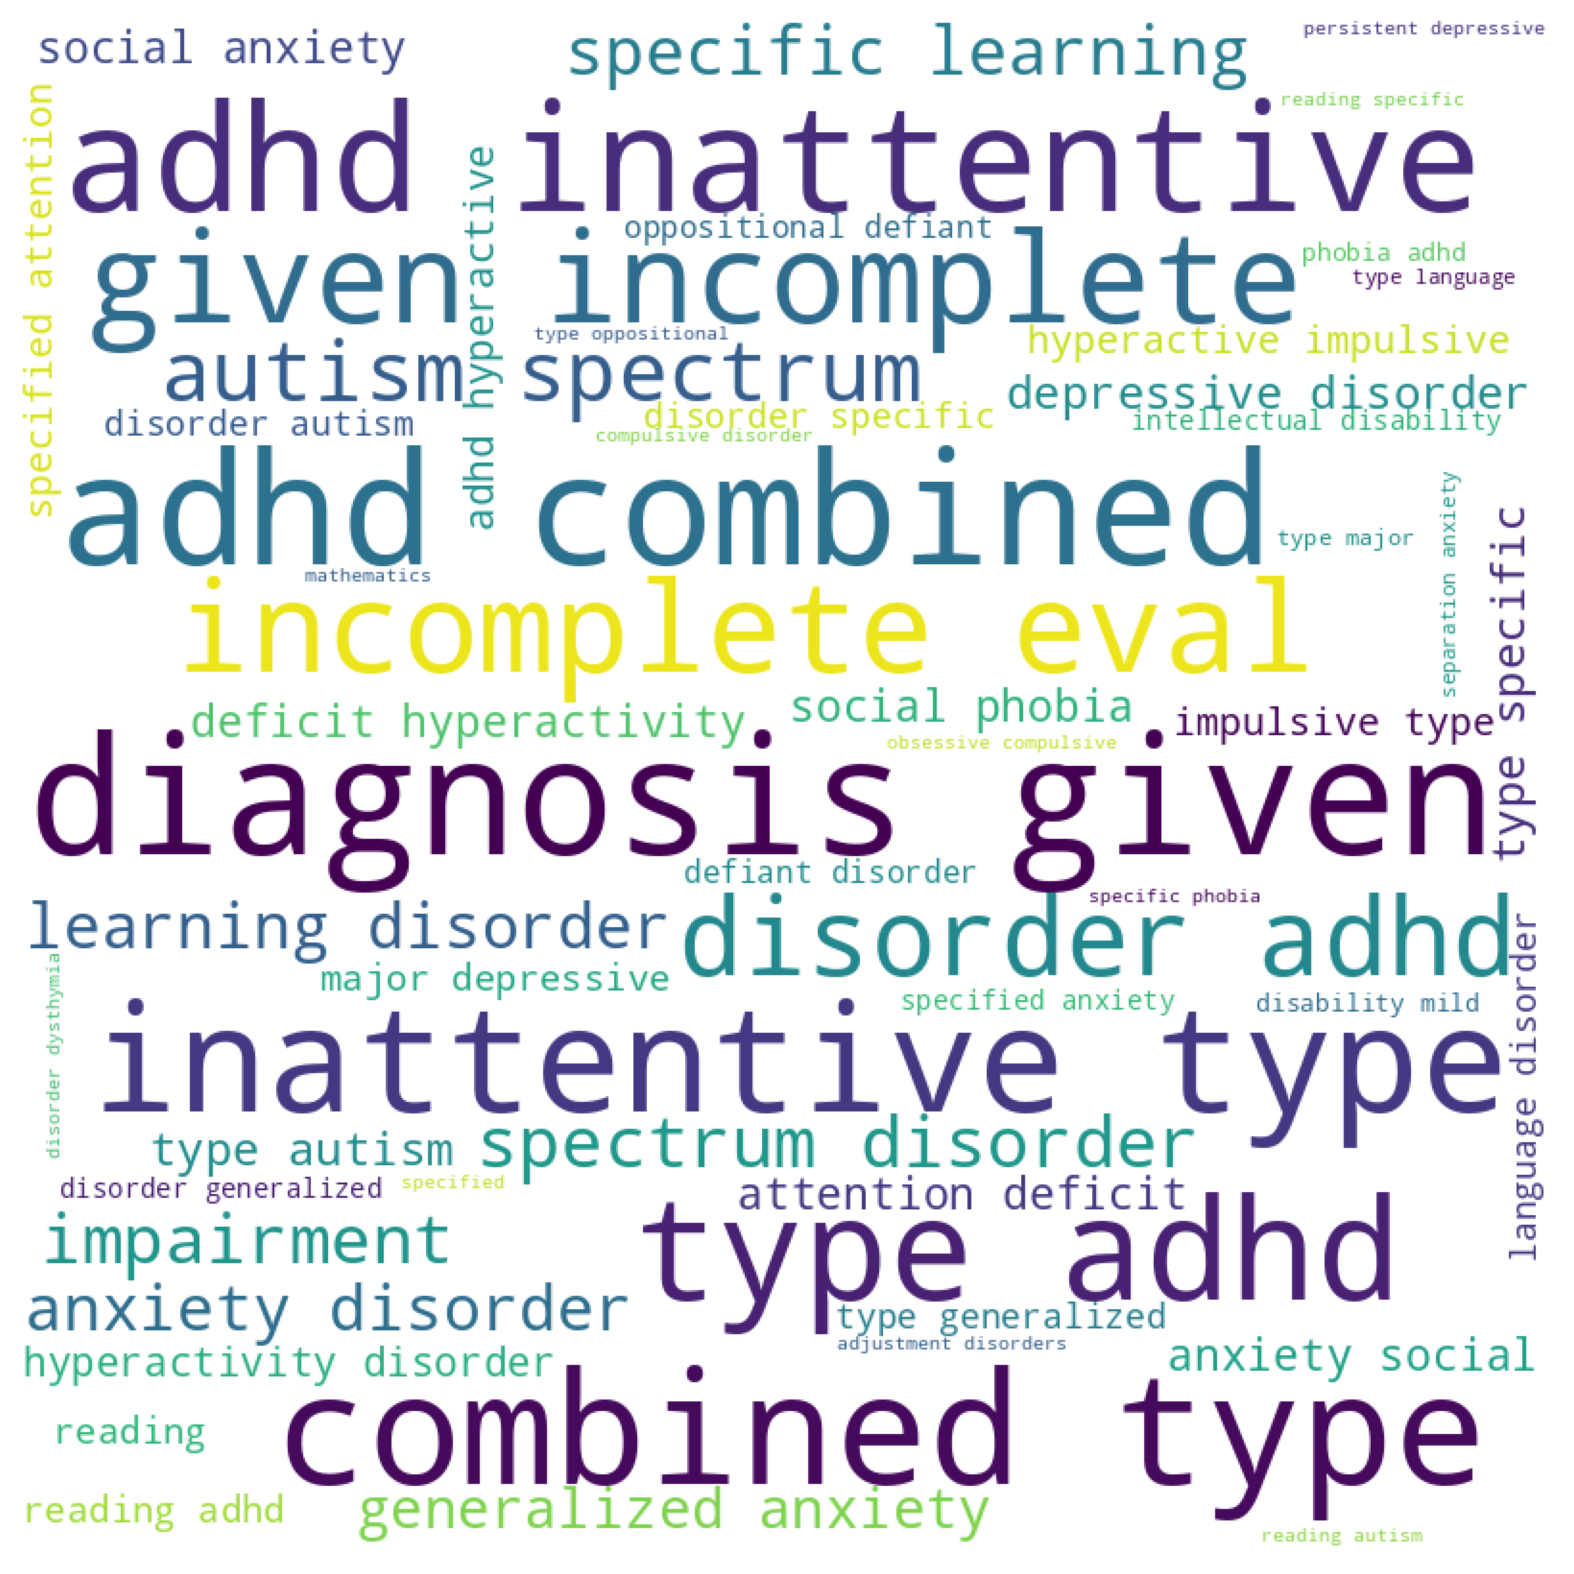

In [7]:
vis.wordcloud(dataframe=df, column='DX_01')

## ADHD is the most diagnosed disorder in the HBN followed by ASD. Most disorders are diagnosed from 5-21 except for hyperactive/impulsive adhd, which isn't diagnosed past 13-14 years

In [8]:
fig = px.scatter(df, x="Identifiers", y="Age", color="DX_01",
                hover_name="DX_01", log_x=False, size_max=60) # size="Age"
fig.update_layout(showlegend=False)
fig.update_xaxes(showticklabels=False, title='Participants')
fig.show()

In [9]:
fig = px.scatter(df, x="Identifiers", y="Age", color="DX_01_Cat",
                hover_name="DX_01_Cat", log_x=False, size_max=60) # size="Age"
fig.update_layout(showlegend=False)
fig.update_xaxes(showticklabels=False, title='Participants')
fig.show()

## Summary plot (grouped by diagnosis)

In [10]:
# group by diagnosis to simplify
diagnosis_grouped = df.groupby(['DX_01', 'DX_01_Cat', 'Sex']).agg({
                'Age': 'mean', 'Identifiers': 'count', 'comorbidities': 'mean'
                }).reset_index()
diagnosis_grouped = diagnosis_grouped.rename({'Identifiers': 'count', 'Age': 'mean_age'}, axis=1)

fig = px.scatter(diagnosis_grouped, x="mean_age", y="count", color="DX_01",
                hover_name="DX_01", log_x=False, size_max=60, size='count') # size="Age"
fig.update_layout(showlegend=False)
fig.update_xaxes(showticklabels=False, title='Age')
fig.update_yaxes(title='Count')
fig.show()

## there are more than double the females with major depressive disorder (including persistent depressive disorder) than males

In [11]:
diagnosis_grouped = df.groupby(['DX_01', 'DX_01_Cat', 'Sex']).agg({
                'Age': 'mean', 'Identifiers': 'count', 'comorbidities': 'mean'
                }).reset_index()
diagnosis_grouped = diagnosis_grouped.rename({'Identifiers': 'count', 'Age': 'mean_age'}, axis=1)

fig = px.bar(diagnosis_grouped.sort_values(by='count', ascending=False).head(45), 
             x='count', y='DX_01', color='Sex', orientation='h')
fig.update_yaxes(title='')
fig.show()

## mood and anxiety disorders are only disorders where females outnumber males

In [12]:
diagnosis_grouped = df.groupby(['DX_01', 'DX_01_Cat', 'Sex']).agg({
                'Age': 'mean', 'Identifiers': 'count', 'comorbidities': 'mean'
                }).reset_index()
diagnosis_grouped = diagnosis_grouped.rename({'Identifiers': 'count', 'Age': 'mean_age'}, axis=1)


fig = px.bar(diagnosis_grouped.groupby(['DX_01_Cat', 'Sex']).sum().reset_index().sort_values(by='count', ascending=False), 
             x='count', y='DX_01_Cat', color='Sex', orientation='h', text='count')
fig.update_yaxes(title='')
fig.show()


## disorders with n>150: neurodevelopmental disorders (including autism, adhd, and neurocognitive/intellectual), anxiety, depression, control group (no diagnosis given)

In [13]:
diagnosis_grouped = df.groupby(['DX_01', 'DX_01_Cat', 'Sex']).agg({
                'Age': 'mean', 'Identifiers': 'count', 'comorbidities': 'mean'
                }).reset_index()
diagnosis_grouped = diagnosis_grouped.rename({'Identifiers': 'count', 'Age': 'mean_age'}, axis=1)


fig = px.bar(diagnosis_grouped.groupby(['DX_01_Cat']).sum().reset_index().sort_values(by='count', ascending=False), 
             x='count', y='DX_01_Cat',  orientation='h', text='count')
fig.update_yaxes(title='')
fig.show()


## 59% of participants have a comorbidity

In [14]:
fig = px.histogram(df, x="comorbidities", nbins=10, color="Sex")
fig.show()

## psychosis disorders have most comorbidities (and females > males)

In [15]:
diagnosis_grouped = df.groupby(['DX_01', 'DX_01_Cat', 'Sex']).agg({
                'Age': 'mean', 'Identifiers': 'count', 'comorbidities': 'mean'
                }).reset_index()
diagnosis_grouped = diagnosis_grouped[diagnosis_grouped['comorbidities']>0]
diagnosis_grouped = diagnosis_grouped.rename({'Identifiers': 'count', 'Age': 'mean_age'}, axis=1)


fig = px.bar(diagnosis_grouped.sort_values(by='comorbidities', ascending=False).head(20), 
             x='comorbidities', y='DX_01', color='Sex', orientation='h')
fig.update_yaxes(title='')
fig.show()


## Majority of sample have a general functioning score between 60-70%

In [16]:
# fig = px.histogram(df, x="CGAS_Score",  nbins=10)
# fig.show()

## Across broad categories, children on the schizophrenia spectrum have the lowest general functioning

In [17]:
# diagnosis_grouped = df.groupby(['DX_01_Cat']).agg({
#                 'Age': 'mean', 'Identifiers': 'count', 'CGAS_Score': 'mean'
#                 }).reset_index()
# diagnosis_grouped = diagnosis_grouped.rename({'Identifiers': 'count', 'Age': 'mean_age'}, axis=1)


# fig = px.bar(diagnosis_grouped, 
#              x='CGAS_Score', y='DX_01_Cat', orientation='h')
# fig.update_yaxes(title='')
# fig.show()